<a href="https://colab.research.google.com/github/Magnus-github/Zaitra_Challenge/blob/UNET/Zaitra_EntryTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zaitra Entry Task

This notebook is a guide on how to run inference on the provided ONNX model. As an exmple, I uploaded the test split of the dataset in order to show what the data pipeline should include.

## Install requirements

First, we need to install the necessary dependencies to run the code.

In [28]:
!pip install onnxruntime
!pip install torch torchvision
!pip install numpy
!pip install scikit-learn
!pip install matplotlib

## Image transform (patchify subscenes and masks)

Next, we define the image transform, which takes care of patchifying the input images into patches of [224x224].

In [29]:
import torch
import torchvision.transforms.v2 as transforms
from torchvision import tv_tensors


class InputTransform:
    def  __init__(self, imsize: int = 224, overlap: int = 20) -> None:
        self._imsize = imsize
        self._stride = imsize - overlap

    def _tile(self, image: torch.Tensor) -> torch.Tensor:
        tilew = image.unfold(1,self._imsize,self._stride)
        tilewh = tilew.unfold(2,self._imsize,self._stride)
        c,tw,th,w,h = tilewh.shape
        tiled_im = tilewh.permute(1,2,0,3,4).reshape(tw*th,c,w,h)
        return tiled_im

    def __call__(self, image: torch.Tensor, mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        tiled_im = self._tile(image)
        tiled_mask = self._tile(mask)
        return tiled_im, tiled_mask


## Dataset

Since this notebook should only contain code for running inference on the model, the dataset class assumes, that the folder containing the scenes, only contains test images. For demonstration, I split the original dataset into 85% train data, 10% validation data and 5% test data and uploaded the test split to my GoogleDrive. The dataset class also assumes that the scene and mask files are NPY files. We split the input image in patches of 224 with an overlap of 20 because we assume an input image size of 1022 and calculate the overlap with the following formula:

Calculate overlap with

224-(orig_size%224)/ceil(orig_size/224)


In [30]:
from torch.utils.data import Dataset, DataLoader

import numpy as np

import os


class CloudsTest(Dataset):
    def __init__(self, data_folder: str = "",
                 scenes_folder: str = "subscenes",
                 masks_folder: str = "masks",
                 image_size: int = 224,
                 overlap: int = 30) -> None:
        super().__init__()
        self._scenes_folder = os.path.join(data_folder, scenes_folder)
        self._masks_folder = os.path.join(data_folder, masks_folder)

        self._transform = InputTransform(image_size, overlap)

        self._scene_files = sorted(os.listdir(self._scenes_folder))
        self._mask_files = sorted(os.listdir(self._masks_folder))


    def __len__(self) -> int:
        return len(self._scene_files)

    def __getitem__(self, idx: int):
        scene_file = self._scene_files[idx]
        mask_file = self._mask_files[idx]

        assert scene_file == mask_file, f"Scene file {scene_file} and mask file {mask_file} do not match"

        scene = np.load(os.path.join(self._scenes_folder, scene_file))
        # get only desired bands (RGB and NIR; bands 4, 3, 2, 8)
        scene = scene[:,:,[3,2,1,7]]
        # normalize to [0, 1]
        scene = (scene - scene.min()) / (scene.max() - scene.min())
        mask = np.load(os.path.join(self._masks_folder, mask_file))
        # use only 'CLOUD' class
        mask = mask[:,:,1][:,:,None]

        scene = torch.tensor(scene.transpose(2,0,1), dtype=torch.float32)
        mask = torch.tensor(mask.transpose(2,0,1), dtype=torch.long)

        tiled_tf_scene, tiled_tf_mask = self._transform(image=scene, mask=mask)

        return tiled_tf_scene, tiled_tf_mask


def collate_fn(batch):
    scenes, masks = zip(*batch)
    scenes = torch.cat(scenes, dim=0)
    masks = torch.cat(masks, dim=0).squeeze(1)
    return scenes, masks

def calculate_overlap(im_size: int):
    return int(np.ceil((224-(im_size%224))/np.ceil(im_size/224)))

def get_dataloader(data_folder: str, batch_size: int = 1) -> DataLoader:
    overlap = calculate_overlap(1022)
    test_dataset = CloudsTest(data_folder, overlap=overlap)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return test_dataloader

## Metrics

We are using the average accuracy and the IoU (intersection over union) metrics to show the performance of the model. The. accuracy score tells us, how many of all pixels the model classified correctly. This measure tends give a poor representation of the model performance, especially, if the only a small part of the image is occupied by the class of interest (in our case, if there is only a small piece of a cloud on one image patch). Thus, we also report the IoU, which gives information about

In [31]:
def compute_iou(pred: torch.Tensor, true: torch.Tensor)  -> float:
        eps=1e-6
        pred = pred.int().cpu()
        true = true.int().cpu()
        intersection = (pred & true).float().sum((1, 2))
        union = (pred | true).float().sum((1, 2))

        iou = (intersection + eps) / (union + eps)

        return iou.mean().item()

def accuracy_metric(pred: torch.Tensor, true: torch.Tensor) -> float:
        return (pred == true).float().mean().item()

# Define logger

In [32]:
import logging
import coloredlogs


logger = logging.getLogger("Inference")
logger.setLevel(level=logging.INFO)
coloredlogs.install(level=logging.INFO, fmt="[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s")

# Inference

In [59]:
import onnxruntime as ort
import torch.nn.functional as F

from typing import Optional


def run_inference(session: ort.InferenceSession, images: torch.Tensor, masks: Optional[torch.Tensor]):
    outputs = session.run(['output'], {'input': images.cpu().numpy()})[0]
    prob = F.sigmoid(torch.tensor(outputs))
    pred = prob.argmax(1)

    if masks is not None:
      test_acc = accuracy_metric(pred, masks)
      test_iou = compute_iou(pred, masks)
    else:
      test_acc = None
      test_iou = None

    return {"prediction": pred, "pixel_acc": test_acc, "IoU": test_iou}

In [39]:
# Load the model and create InferenceSession
model_path = "/content/drive/MyDrive/ZaitraChallenge/model/DeepLabv3_ReduceLROnPlateau_final.onnx"
session = ort.InferenceSession(model_path)
# The data folder is expected to contain two folders (masks and subscenes) that each contain NPY files
data_folder = "/content/drive/MyDrive/ZaitraChallenge/Data/test/"
# Load and preprocess the input image inputTensor

dataloader = get_dataloader(data_folder)

images, masks = next(iter(dataloader))

logger.info(f"Images shape: {images.shape}")
logger.info(f"Masks shape: {masks.shape}")

[2024-06-01 13:58:11] [Inference] [INFO] Images shape: torch.Size([16, 4, 224, 224])
[2024-06-01 13:58:11] [Inference] [INFO] Masks shape: torch.Size([16, 224, 224])


  0%|          | 0/24 [00:00<?, ?it/s][2024-06-01 14:18:17] [Inference] [INFO] Batch 0, Accuracy: 0.07667884230613708, IoU: 2.1590253890257927e-11


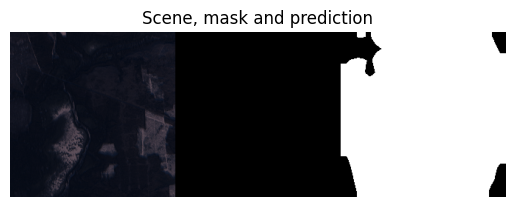

  4%|▍         | 1/24 [00:01<00:37,  1.63s/it][2024-06-01 14:18:19] [Inference] [INFO] Batch 1, Accuracy: 0.9998990893363953, IoU: 0.9998990893363953


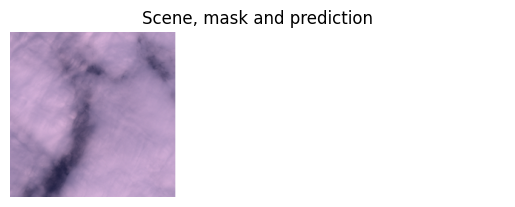

  8%|▊         | 2/24 [00:03<00:35,  1.62s/it][2024-06-01 14:18:20] [Inference] [INFO] Batch 2, Accuracy: 0.9990533590316772, IoU: 0.9990532994270325


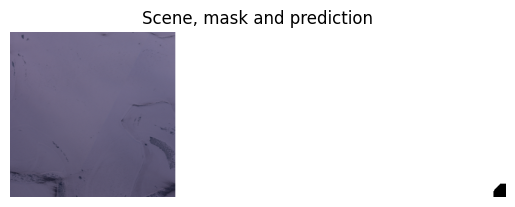

 12%|█▎        | 3/24 [00:04<00:33,  1.60s/it][2024-06-01 14:18:22] [Inference] [INFO] Batch 3, Accuracy: 1.0, IoU: 1.0


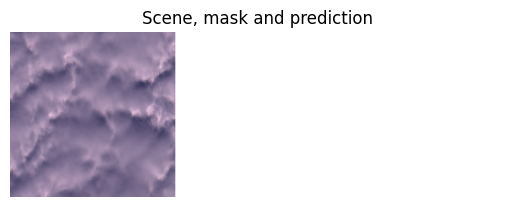

 17%|█▋        | 4/24 [00:06<00:31,  1.56s/it][2024-06-01 14:18:23] [Inference] [INFO] Batch 4, Accuracy: 0.008285833522677422, IoU: 0.0061162495985627174


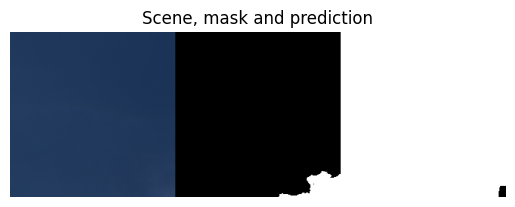

 21%|██        | 5/24 [00:07<00:28,  1.51s/it][2024-06-01 14:18:26] [Inference] [INFO] Batch 5, Accuracy: 0.5353094339370728, IoU: 0.4711037874221802


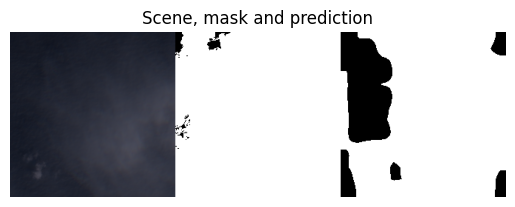

 25%|██▌       | 6/24 [00:10<00:36,  2.02s/it][2024-06-01 14:18:28] [Inference] [INFO] Batch 6, Accuracy: 0.9936187267303467, IoU: 0.9936187267303467


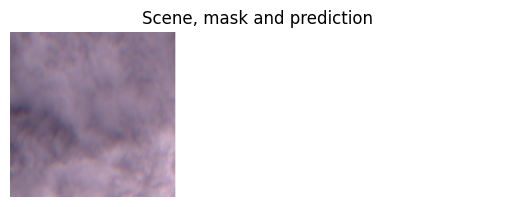

 29%|██▉       | 7/24 [00:12<00:33,  1.96s/it][2024-06-01 14:18:29] [Inference] [INFO] Batch 7, Accuracy: 0.0250418521463871, IoU: 2.0442330120329366e-11


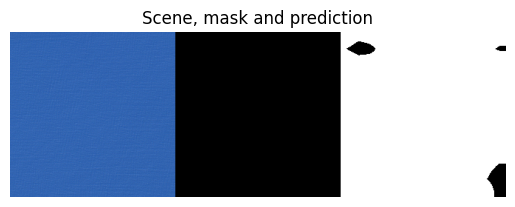

 33%|███▎      | 8/24 [00:13<00:27,  1.74s/it][2024-06-01 14:18:31] [Inference] [INFO] Batch 8, Accuracy: 0.08404042571783066, IoU: 2.182470697220662e-11


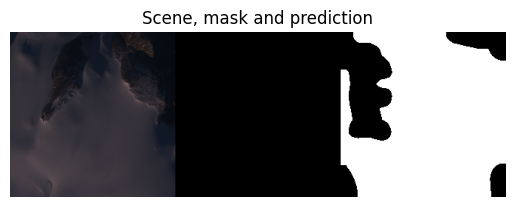

 38%|███▊      | 9/24 [00:15<00:23,  1.58s/it][2024-06-01 14:18:32] [Inference] [INFO] Batch 9, Accuracy: 0.9420913457870483, IoU: 0.9409826397895813


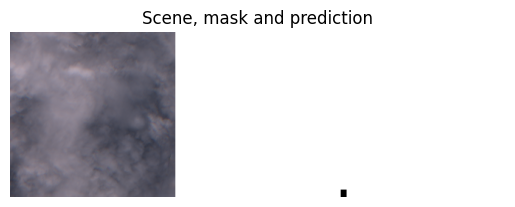

 42%|████▏     | 10/24 [00:16<00:20,  1.49s/it][2024-06-01 14:18:33] [Inference] [INFO] Batch 10, Accuracy: 0.36149752140045166, IoU: 0.24636052548885345


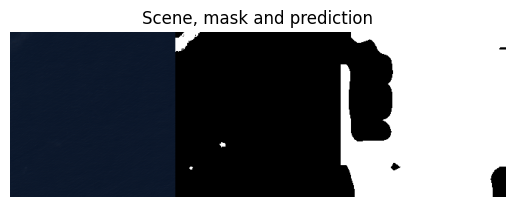

 46%|████▌     | 11/24 [00:17<00:18,  1.43s/it][2024-06-01 14:18:35] [Inference] [INFO] Batch 11, Accuracy: 0.8217188119888306, IoU: 0.8195942640304565


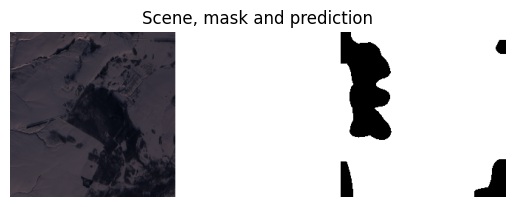

100%|██████████| 24/24 [00:33<00:00,  1.40s/it]
[2024-06-01 14:18:49] [Inference] [INFO] Total accuracy: 0.4641172461876219, Total IoU: 0.42682124803083904


In [62]:
import matplotlib.pyplot as plt
from tqdm import tqdm

display = True
running_acc = 0.0
running_iou = 0.0
for i, (images, masks) in enumerate(tqdm(dataloader)):
    out = run_inference(session, images, masks)
    if out["pixel_acc"]:
      acc = out["pixel_acc"]
      iou = out["IoU"]
      running_acc += acc
      running_iou += iou
      logger.info(f"Batch {i}, Accuracy: {acc}, IoU: {iou}")

    if display:
      pred = out["prediction"]
      # display one patch (image, gt_mask, pred)
      figure = plt.figure(1)
      plt_im_mask_pred  = images[13].to("cpu").numpy().transpose(1,2,0)[:,:,:3]
      mask_repeat = masks[13].to("cpu").numpy()[None,:,:]
      mask_repeat = np.repeat(mask_repeat, 3, axis=0).transpose(1,2,0)
      pred_repeat = pred[13].to("cpu").numpy()[None,:,:]
      pred_repeat = np.repeat(pred_repeat, 3, axis=0).transpose(1,2,0)
      plt_im_mask_pred = np.concatenate([plt_im_mask_pred, mask_repeat, pred_repeat], axis=1)
      plt.imshow(plt_im_mask_pred)
      plt.title("Scene, mask and prediction")
      plt.axis("off")
      plt.show()

    if i > 10:
      display = False

total_acc = running_acc / len(dataloader)
total_iou = running_iou / len(dataloader)

logger.info(f"Total accuracy: {total_acc}, Total IoU: {total_iou}")